# Differences between Rotten Tomatoes' Tomatometer and Audience score - filtered by genre.
Does the difference between critic score and audience score vary by genre. The project's idea is to mine the famous [Rotten Tomatoes](https://www.rottentomatoes.com) for the scores of movies and then look-up the genres in [IMDB](https://www.imdb.com/).

The Rotten Tomatoes scores are only for DVD releases.

Once I got the data I will store it in a MySQL database and query from there.

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlencode
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from sqlalchemy import *
from sqlalchemy.orm import sessionmaker
import json
import requests
import numpy as np

In [3]:
# Defining the options for our browser
chrome_options = Options()
chrome_options.add_argument("--headless") # to not display the page

# Defining the drivers and the URL
driver = webdriver.Chrome(chrome_options=chrome_options)
driver.get('https://www.rottentomatoes.com/browse/dvd-streaming-all/')

In [2]:
# Loading the Connection String + database
DB_CON = json.loads(open('dbcon.json').read())['db']
OMBDB_KEY = json.loads(open('apikey.json').read())['key']

## Scraping Rotten Tomatoes

In [4]:
# Scraping Functions
def get_movie_count(webdriver):
    html = BeautifulSoup(webdriver.page_source, 'html.parser')
    init_movie_count = html.find(attrs={"id": "count-link"}).findAll('span')[2].text.split()[1]
    movie_count = html.find(attrs={"id": "count-link"}).findAll('span')[2].text.split()[-1]
    
    return int(init_movie_count), int(movie_count)

def click_on_show_more(webdriver):
    webdriver.find_element_by_css_selector('.mb-load-btn').click()
    # no returns

def scrape_all_movies(webdriver):
    '''
    The function takes the webdriver and return the whole page source for further work.
    '''
    init_count, total_count = get_movie_count(webdriver)
    
    while init_count < total_count:
        click_on_show_more(webdriver)
        init_count, total_count = get_movie_count(webdriver)
    
    return webdriver.page_source

In [ ]:
# Scraping the actual page - can take a lot of time... get a coffee.
html = scrape_all_movies(driver)

In [5]:
def get_all_movies(html):
    soup_page = BeautifulSoup(html, 'html.parser')
    movie_infos = soup_page.find_all(attrs={'class':'movie_info'})
    
    movies = []
    for info in movie_infos:
        if len(info.find_all(attrs={'class':'tMeterScore'})) == 2:
            # filter the released movies that have both - the viewer and the critic scores
            movie = { 'title': info.find(attrs={'class':'movieTitle'}).text,
                      'critic_score':int(info.find_all(attrs={'class':'tMeterScore'})[0].text.strip('%')),
                      'viewer_score':int(info.find_all(attrs={'class':'tMeterScore'})[1].text.strip('%'))
                    }
            movies.append(movie)
            
    return movies

In [ ]:
rt_movies = get_all_movies(html)

## Scraping IMDB
Here I cheated a bit. Instead of scraping IMDB, I opted out for using the excellent unofficial IMDB database [omdbapi.com](http://www.omdbapi.com) and used the provided API to check the genre of each movie scraped from Rotten Tomatoes.

In [9]:
rtmovs = get_rt_movies_all()

In [10]:
# Functions for getting the movies
def get_movie(title):
    title_url = urlencode({'t':title})
    url = 'http://www.omdbapi.com/?apikey=' + OMBDB_KEY + '&' + title_url
    r = requests.get(url)
    if r.status_code == 200:
        return r.json()
    else:
        return {
            'Title':title,
            'Genre':'N\A',
            'imdbRating':'N\A',
            'Response':'True',
            'Released':'N\A'
        }

def try_convert_score(value):
    try:
        val = value
    except ValueError:
        val = 'N/A'
    
    return val

def get_imdb_movies(movies):
    imdb_movies = []
    for movie in movies:
        imdb_res = get_movie(movie['title'])
        if imdb_res['Response'] == 'True':
            imdb_movie = {
                'title': imdb_res['Title'],
                'genre': imdb_res['Genre'],
                'imdbRating': try_convert_score(imdb_res['imdbRating']),
                'Released':try_convert_score(imdb_res['Released'])
            }
            imdb_movies.append(imdb_movie)
        
    return imdb_movies

In [11]:
imdb_movies = get_imdb_movies(rtmovs)

## Uploading to MySQL Database

In [3]:
def db_tables():
    # create the engine
    metadata = MetaData()
        
    rt_movies = Table('rt_movies', metadata,
                    Column('id', Integer, primary_key=True),
                    Column('title', String),
                    Column('critic_score', Integer),
                    Column('viewer_score', Integer))
    
    imdb_movies = Table('imdb_movies', metadata,
                      Column('id', Integer, primary_key=True),
                      Column('title', String),
                      Column('genre', String),
                      Column('imdbRating', String),
                      Column('Released', String))
    
    return rt_movies, imdb_movies

def db_upload(data, engine, table):
    if table.name == 'rt_movies':
        ins = table.insert().values(
            title = data['title'],
            critic_score = data['critic_score'],
            viewer_score = data['viewer_score']
        )
    else:
        ins = table.insert().values(
            title = data['title'],
            genre = data['genre'],
            imdbRating = data['imdbRating'],
            Released = data['Released']
        )
    
    connection = engine.connect()
    connection.execute(ins)

In [4]:
rt_movies_table, imdb_movies_table = db_tables()

In [5]:
dbengine = create_engine(DB_CON)

In [8]:
# fast and simple query to get the RT movies from the database instead of re-doing the whole RT Scraping
def get_rt_movies_all():
    Session = sessionmaker(bind=dbengine)
    session = Session()
    movies = session.query(rt_movies_table).all()
    rtmovies = []
    for movie in movies:
        rtmovies.append({'title':movie[1]})
    
    return rtmovies

In [ ]:
# UPLOAD the data
for rt_movie in rt_movies:
    db_upload(rt_movie, dbengine, rt_movies_table)

In [15]:
for imdb_movie in imdb_movies:
    db_upload(imdb_movie, dbengine, imdb_movies_table)

## Getting the data from the database
Although the `pandas` package can handle all of the extraction from the mySQL db, I want to take the hard route and do it all in SQL - just for practice from which I will create the PD dataframes.

In [6]:
# Secondary Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [7]:
def exec_sql(sql):
    '''
    Takes an SQL statement as input and returns an itterable sqlalchemy engine
    '''
    statement = text(sql)
    return dbengine.execute(statement)

In [8]:
imdb_movs = exec_sql('SELECT * FROM imdb_movies LIMIT 1') # sample query IMDB
rt_movs = exec_sql('SELECT * FROM rt_movies LIMIT 1') # sample query Rotten Tomatoes Movies

In [9]:
for item in imdb_movs:
    print(item)

for item in rt_movs:
    print(item)

(9937, "God's Not Dead: A Light in Darkness", 'Drama', '3.8', '30 Mar 2018')
(1, "God's Not Dead: A Light in Darkness", 13, 53)


## Analysis
So again - the goal is to answer the questions:
1. Mean difference between scores (critic and viewer) in time?
2. Is there a difference between the genres in the mean values for the Rotten Tomatoes `mean critic score` and `mean user score`?
3. How does this vary in time (years)?

In [11]:
# Lets define a function that will take the data from the SQL query and turn it to a dataframe
# ... yes, I know I can do that directly from pandas...
def to_df(query_res, columns_list):
    data = []
    for item in query_res:
        data.append(list(item))
    
    return pd.DataFrame(data, columns = columns_list)

### 1. Mean difference between scores (critic and viewer) in time?

In [11]:
sql = '''SELECT  ROUND(AVG(A.`critic_score`),2), ROUND(AVG(A.`viewer_score`),2), RIGHT(B.`Released`,4)
       FROM `rt_movies` AS A
       INNER JOIN `imdb_movies` AS B 
       ON A.`title` = B.`title`
       GROUP BY RIGHT(B.`Released`, 4)'''
rt_imdb_table = exec_sql(sql)

In [12]:
# Convert the response to a dataframe
rt_imdb_df = to_df(rt_imdb_table, ['mean_critic_score','mean_viewer_score','year'])

In [13]:
# Check the head
rt_imdb_df.head()

,mean_critic_score,mean_viewer_score,year
0,57.00,50.00,1907
1,76.00,65.00,1915
2,94.00,69.00,1920
3,80.00,75.00,1921
4,97.00,93.00,1923


In [14]:
rt_imdb_df.tail()

,mean_critic_score,mean_viewer_score,year
96,59.40,55.03,2016
97,61.57,58.00,2017
98,55.23,57.03,2018
99,60.62,58.59,N/A
100,100.00,43.00,N\A


Whoops - some N/A values have snuck through and its only the last 2 rows - I will drop them.

In [15]:
rt_imdb_df = rt_imdb_df.drop([99,100])

In [16]:
rt_imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 3 columns):
mean_critic_score    99 non-null object
mean_viewer_score    99 non-null object
year                 99 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


Since the `mean_critic_score` and `mean_viewer_score` are not the right type we need to convert them

In [17]:
rt_imdb_df[['year','mean_critic_score','mean_viewer_score']] = rt_imdb_df[['year','mean_critic_score','mean_viewer_score']].apply(pd.to_numeric)

In [18]:
# melting
rt_imdb_df = rt_imdb_df.melt('year', var_name='score_type', value_name='value')

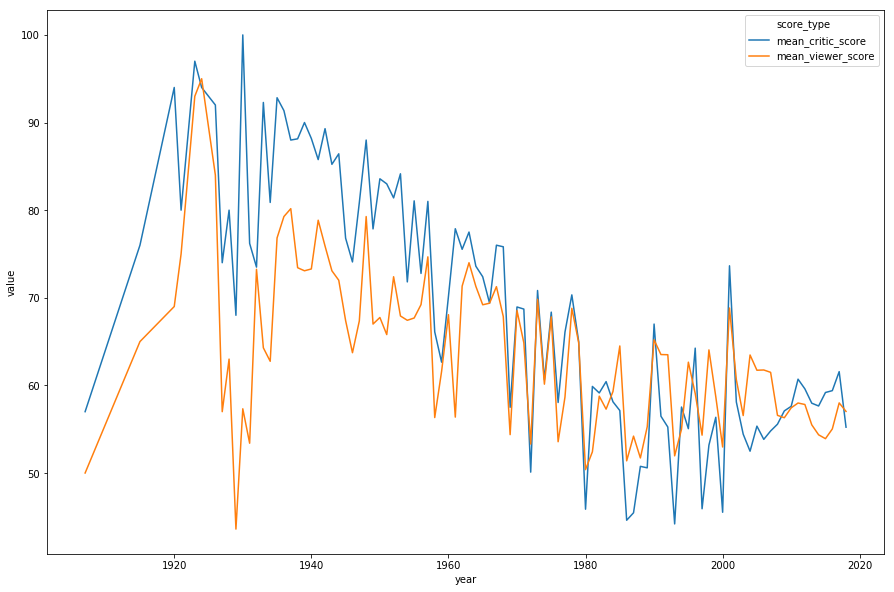

In [19]:
# plotting
plt.subplots(figsize=(15,10))
sns.lineplot(x='year',y='value', hue='score_type', data=rt_imdb_df)

It seems that in the 20s, as well as from the 60s trhough the 80s the `mean_viewer_score` follows closely the viewer score. Howerever, with the advent of 2000s the things radically change, as the `mean_viewer_score` and `mean_critic_score` seems to be opposite. Let's plot the difference by itself.

In [34]:
sql = '''SELECT  ABS(ROUND(AVG(A.`critic_score`),2) - ROUND(AVG(A.`viewer_score`),2)) AS Score_Diff, RIGHT(B.`Released`,4)
       FROM `rt_movies` AS A
       INNER JOIN `imdb_movies` AS B 
       ON A.`title` = B.`title`
       GROUP BY RIGHT(B.`Released`, 4)'''
score_diff = exec_sql(sql)
score_diff_df = to_df(score_diff, ['score_diff','year'])
score_diff_df = score_diff_df.drop([99,100])
score_diff_df[['score_diff', 'year']] = score_diff_df[['score_diff', 'year']].apply(pd.to_numeric)

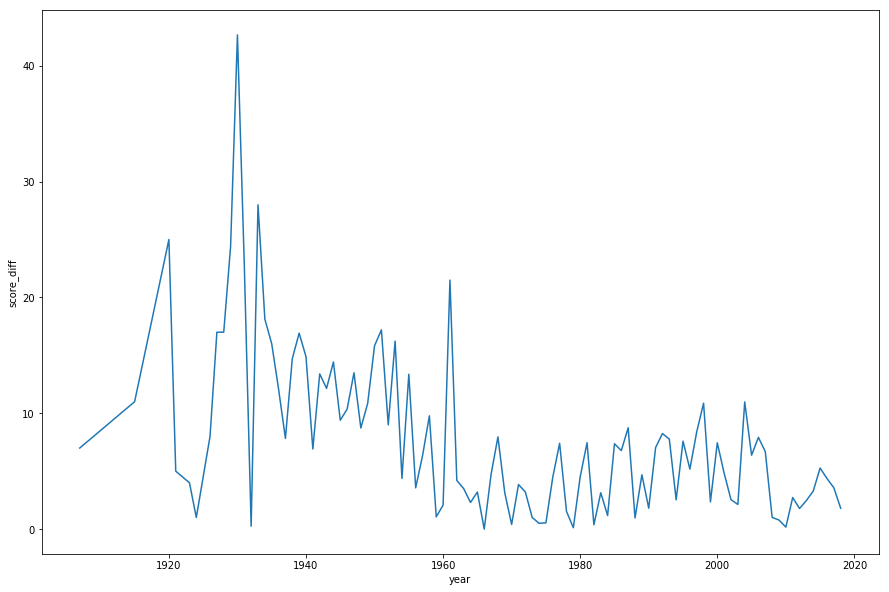

In [35]:
# plot the scores
plt.subplots(figsize=(15,10))
sns.lineplot(x='year',y='score_diff', data=score_diff_df)

Overall it seems that the absolute score difference is steady the last 60 years of movie making.

### 2. Is there a difference between the genres in the mean values for the Rotten Tomatoes *mean critic score* and *mean user score*?

#### 2.1 Setup
First we need to find out how to handle movies with multiple genres.

In [36]:
# Demonstrating Genres
sql = '''SELECT *
       FROM `imdb_movies`
       LIMIT 10'''
genre_table = exec_sql(sql)

In [37]:
for res in genre_table:
    print(res)

(9937, "God's Not Dead: A Light in Darkness", 'Drama', '3.8', '30 Mar 2018')
(9938, 'Show Dogs', 'Adventure, Comedy, Family', '3.3', '18 May 2018')
(9939, 'Action Point', 'Comedy', '4.9', '01 Jun 2018')
(9940, 'Tag', 'Comedy', '6.6', '15 Jun 2018')
(9941, 'Western', 'Drama', '7.2', '24 Aug 2017')
(9942, 'A Kid Like Jake', 'Drama, Family', '5.0', '01 Jun 2018')
(9943, 'Mary Shelley', 'Biography, Drama, Romance', '6.3', '06 Jul 2018')
(9944, 'Woman Walks Ahead', 'Biography, Drama, History', '6.0', '29 Jun 2018')
(9945, 'The Little Vampire 3D', 'Animation, Adventure, Comedy', '5.4', '04 Oct 2017')
(9946, 'RBG', 'Documentary, Biography', '7.5', '14 Sep 2018')


From the results by query it seems that a movie is not assigned just 1 genre, but a multitude of values. Thus I will get all the genres and create a vector for each movie, whether it gets all the genres right.

In [11]:
sql = '''SELECT DISTINCT `genre` FROM `imdb_movies`'''
distinct_genres = exec_sql(sql)

In [12]:
# Define the Dict where the genres will be stored
genre_glossary = []
# Go through the results
for res in distinct_genres:
    # strip the chars we don't need
    res = str(res).strip(")").strip("(").replace("'", "").replace(" ", "").split(",") # There's an easier way... I guess...
    # remove the empty items in the arrays
    res = list(filter(None, res))
    # Go through the items in the results
    for item in res:
        if item not in genre_glossary:
            genre_glossary.append(item)

In [13]:
# Let's sort it and see what we have here
genre_glossary = sorted(genre_glossary)
genre_glossary

['Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'N/A',
 'N\\\\A',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [14]:
# Double entries of 'N/A' - lets remove them
genre_glossary.remove('N/A')
genre_glossary.remove('N\\\\A')

In [15]:
# Create a dict to record items in it
genre_glossary_dict = {}
for genre in genre_glossary:
    genre_glossary_dict[genre] = 0

Now we have the unique genres. Now what is left is to compose a function that given the genres will return a *genre* vector.

In [83]:
def gen_vector(genres, glossary):
    # check each item in the genres array
    new_glossary = glossary.copy()
    for genre in genres:
        new_glossary[genre] = 1
    
    return new_glossary

In [85]:
# Lets test it
sql = '''SELECT *
       FROM `imdb_movies`
       LIMIT 10'''
movies = exec_sql(sql)

for movie in movies:
    movie_genres = movie[2].replace(" ","").split(",")
    genre_vector = gen_vector(movie_genres, genre_glossary_dict)
    print(movie_genres)
    print(list(genre_vector.values()))

['Drama']
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Adventure', 'Comedy', 'Family']
[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Comedy']
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Comedy']
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Drama']
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Drama', 'Family']
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Biography', 'Drama', 'Romance']
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
['Biography', 'Drama', 'History']
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Animation', 'Adventure', 'Comedy']
[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Documentary', 'Biography']
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0

This is good, however we will need to create a table into the database to store this information. The table will contain just the movie title and the genre vector as a string.

In [90]:
metadata = MetaData()
# create the table
movie_genres = Table('movie_genres', metadata,
                     Column('id', Integer, primary_key=True),
                     Column('title', String(255)),
                     Column('Action', Integer),
                     Column('Adult', Integer),
                     Column('Adventure', Integer),
                     Column('Animation', Integer),
                     Column('Biography', Integer),
                     Column('Comedy', Integer),
                     Column('Crime', Integer),
                     Column('Documentary', Integer),
                     Column('Drama', Integer),
                     Column('Family', Integer),
                     Column('Fantasy', Integer),
                     Column('FilmNoir', Integer),
                     Column('GameShow', Integer),
                     Column('History', Integer),
                     Column('Horror', Integer),
                     Column('Music', Integer),
                     Column('Musical', Integer),
                     Column('Mystery', Integer),
                     Column('News', Integer),
                     Column('RealityTV', Integer),
                     Column('Romance', Integer),
                     Column('SciFi', Integer),
                     Column('Short', Integer),
                     Column('Sport', Integer),
                     Column('Thriller', Integer),
                     Column('War', Integer),
                     Column('Western', Integer))
metadata.create_all(dbengine.connect())

In [91]:
# Query from the first db
sql = '''SELECT * 
         FROM `imdb_movies`'''
movies = exec_sql(sql)

In [93]:
# Upload to DB
for movie in movies:
    genres = movie[2].replace(" ","").split(",")
    genre_dict = gen_vector(genres, genre_glossary_dict)
    ins = movie_genres.insert().values(
          title = movie[1],
          Action = genre_dict['Action'],
          Adult = genre_dict['Adult'],
          Adventure = genre_dict['Adventure'],
          Animation = genre_dict['Animation'],
          Biography = genre_dict['Biography'],
          Comedy = genre_dict['Comedy'],
          Crime = genre_dict['Crime'],
          Documentary = genre_dict['Documentary'],
          Drama = genre_dict['Drama'],
          Family = genre_dict['Family'],
          Fantasy = genre_dict['Fantasy'],
          FilmNoir = genre_dict['Film-Noir'],
          GameShow = genre_dict['Game-Show'],
          History = genre_dict['History'],
          Horror = genre_dict['Horror'],
          Music = genre_dict['Music'],
          Musical = genre_dict['Musical'],
          Mystery = genre_dict['Mystery'],
          News = genre_dict['News'],
          RealityTV = genre_dict['Reality-TV'],
          Romance = genre_dict['Romance'],
          SciFi = genre_dict['Sci-Fi'],
          Short = genre_dict['Short'],
          Sport = genre_dict['Sport'],
          Thriller = genre_dict['Thriller'],
          War = genre_dict['War'],
          Western = genre_dict['Western'],
    )
    
    connection = dbengine.connect()
    connection.execute(ins)

#### 2.2 Analysis
Now that the upload is done we can move to the analysis. I will loop through each genre and group by it.

In [25]:
genre_score_list = []
for genre in genre_glossary:
    # since we removed the dashes in the names - perform that again
    genre = genre.replace('-','')
    sql = '''SELECT + `''' + genre + '''`, ROUND(AVG(A.`critic_score`),2), ROUND(AVG(A.`viewer_score`),2)
           FROM `rt_movies` AS A
           INNER JOIN `movie_genres` AS B 
           ON A.`title` = B.`title`
           GROUP BY `''' + genre + '''`'''
    
    res = exec_sql(sql)
    for line in res:
        if line[0] == 1:
            genre_score_list.append([genre, float(line[1]), float(line[2])])

In [30]:
genre_df = pd.DataFrame(columns=['genre', 'critic_score', 'viewer_score'])

In [32]:
for i in range(len(genre_score_list)):
    genre_df.loc[i] = genre_score_list[i]

In [33]:
genre_df.head()

,genre,critic_score,viewer_score
0,Action,47.58,53.72
1,Adult,81.00,100.00
2,Adventure,55.16,58.67
3,Animation,61.08,62.72
4,Biography,72.06,70.06


In [53]:
# for the purpose of plotting we need to assign ids to the genre
# we know that the genres are 27 so just a simple loop will do
genre_df['genre_id'] = [i for i in range(len(genre_df))]

In [60]:
# melting
genre_melt_df = genre_df.melt(id_vars=['genre_id'], value_vars=['critic_score', 'viewer_score'], var_name='score_type', value_name='value')

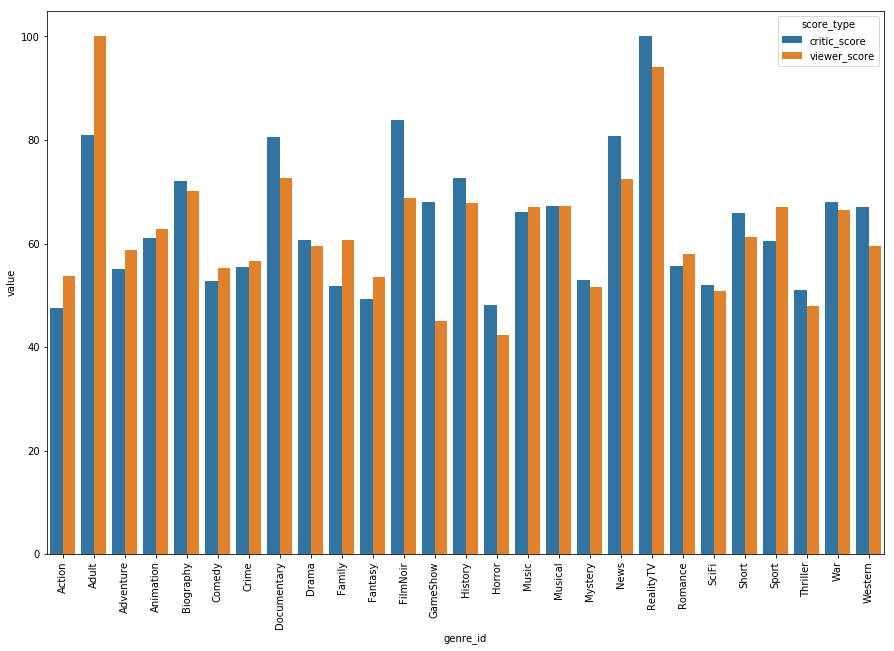

In [83]:
# plotting
plt.subplots(figsize=(15,10))
ax = sns.barplot(x='genre_id', y='value', hue='score_type', data=genre_melt_df)
ax.set_xticklabels(list(genre_df['genre'].values), rotation=90)
plt.show()

Although in general both scores per genre seem close, it seems that *Game Shows* are getting better review from critics, than what users, while users like *Action*, *Adult*, *Family* and *Sport* movies more.  

## 3. How does this vary in time (years)?

In [154]:
genre_score_year_list = pd.DataFrame(columns=['genre','critic_score', 'viewer_score', 'year']) # empty DF to store data to
for genre in genre_glossary:
    # since we removed the dashes in the names - perform that again
    genre = genre.replace('-','')
    sql = '''SELECT + C.`''' + genre + '''`, ROUND(AVG(A.`critic_score`),2), ROUND(AVG(A.`viewer_score`),2), RIGHT(B.`Released`,4)
           FROM `rt_movies` AS A
           INNER JOIN `imdb_movies` AS B 
           ON A.`title` = B.`title`
           INNER JOIN `movie_genres` AS C 
           ON A.`title` = C.`title` 
           WHERE C.`''' + genre + '''` = 1
           GROUP BY RIGHT(B.`Released`, 4), C.`''' + genre + '''`'''
    
    res = exec_sql(sql)
    
    for line in res:
        # skip the 'N/A' year
        if line[3] == 'N/A':
            pass
        else:
            genre_score_year_list = genre_score_year_list.append(pd.DataFrame([[genre, float(line[1]), float(line[2]), int(line[3])]], 
                                                                              columns=['genre','critic_score', 'viewer_score', 'year']))

In [155]:
# get the head
genre_score_year_list.head()

,genre,critic_score,viewer_score,year
0,Action,94.0,95.0,1924
0,Action,91.0,75.0,1931
0,Action,100.0,89.0,1935
0,Action,67.0,54.0,1938
0,Action,100.0,89.0,1939


Since I don't expect each genre to be represented each year, lets count to see the genre with the most number of years.

In [156]:
def most_repr_genre():
    temp_df = pd.DataFrame(columns=['genre', 'count'])
    for genre in genre_glossary:
        count = genre_score_year_list[genre_score_year_list['genre'] == genre].count()['genre']
        temp_df = temp_df.append(pd.DataFrame([[genre, count]], columns=['genre', 'count']))
        
    return temp_df.loc[temp_df['count'] == temp_df['count'].max()]

In [157]:
most_made_genre = most_repr_genre()
most_made_genre

,genre,count
0,Drama,97


It seems drama is the most represented.

In [158]:
# melting
genre_syl_melt_df = genre_score_year_list.melt(id_vars=['year','genre'], value_vars=['critic_score', 'viewer_score'], var_name='score_type', value_name='value')
# to numeric
genre_syl_melt_df[['year','value']] = genre_syl_melt_df[['year','value']].apply(pd.to_numeric)

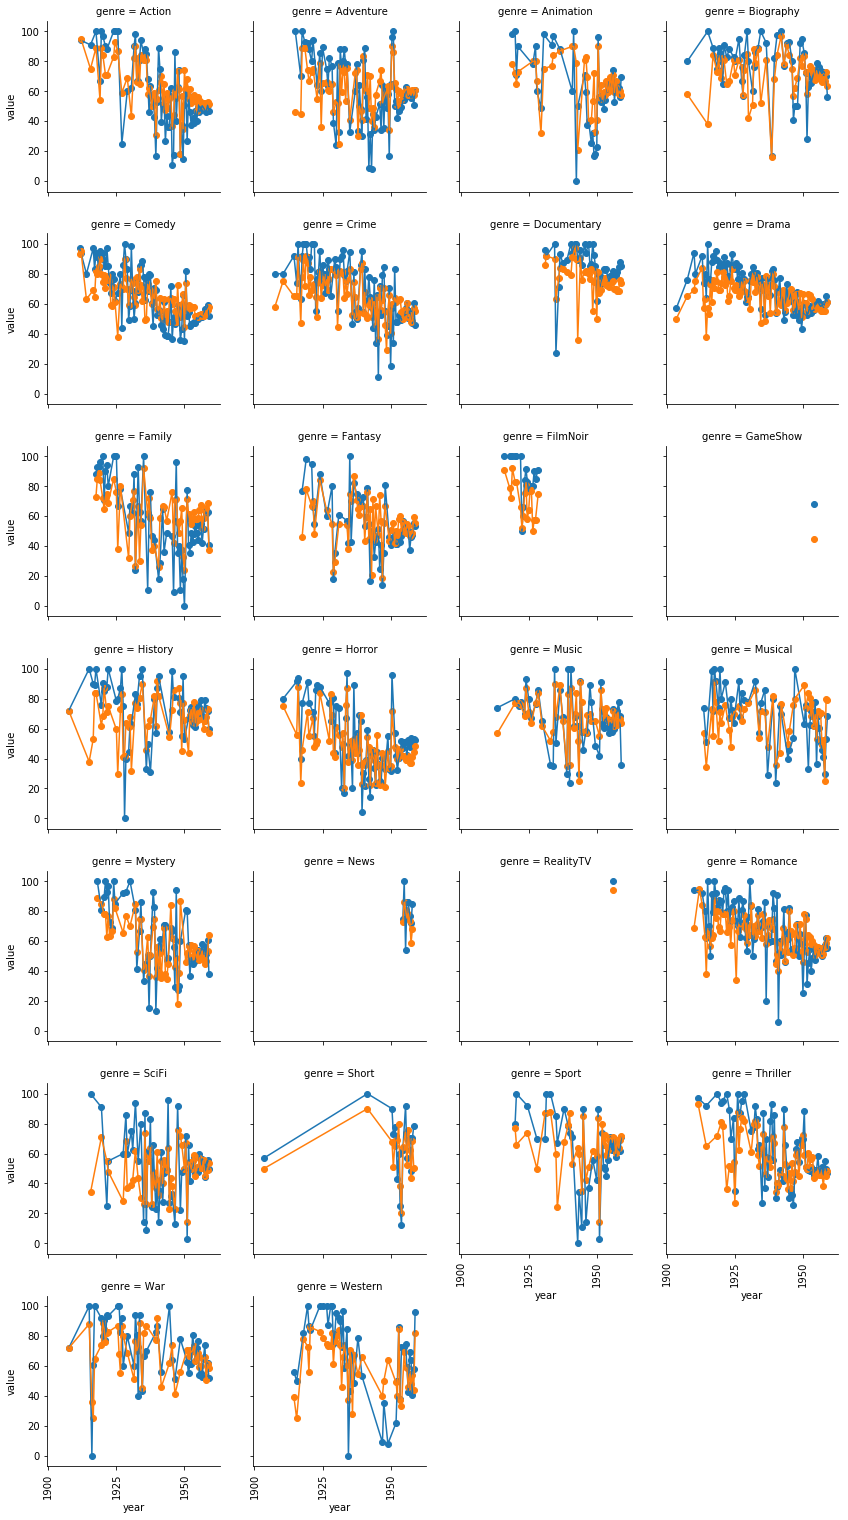

In [168]:
# plotting
g = sns.FacetGrid(genre_syl_melt_df, col='genre', hue='score_type', col_wrap=4, legend_out=True)
g.map(plt.scatter, 'year', 'value')
g.map(plt.plot, 'year','value')
g.set_xticklabels(rotation=90)
plt.show()

Each of the plots diserve a detailed investigation, but a general conclusion would be:
* Shorts weren't really a thing before the 50s.
* Noirs generally died with black-and-white cinema. No surprise there.
* News, Reality and GameShows are a relatively new thing. 
* Musicals and somewhat Music'scores stayed relatively the same with time. All other genres drop in scores, both critic and viewer, after the 2000.